In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from deepface import DeepFace




In [9]:
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from DLAIUtils import Utils

In [5]:
import contextlib
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import time

In [11]:
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

In [12]:
!wget -q --show-progress -O family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

family_photos.zip   100%[===================>] 774.04K  --.-KB/s    in 0.1s    


In [13]:
!unzip -q family_photos.zip

replace family/dad/P11969_face8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


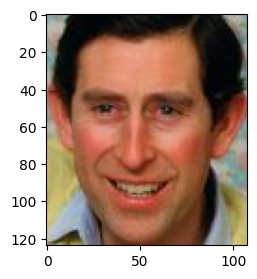

In [15]:
def show_img(f):
    img = plt.imread(f)
    plt.figure(figsize = (4,3))
    plt.imshow(img)

show_img('./family/dad/P06260_face5.jpg')

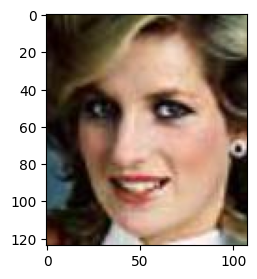

In [16]:
show_img('family/mom/P04407_face2.jpg')

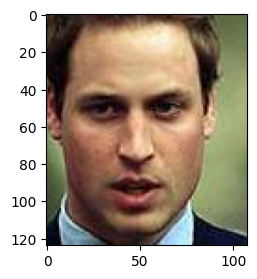

In [8]:
show_img('family/child/P04414_face1.jpg')

In [17]:
MODEL = "Facenet"
INDEX_NAME = utils.create_dlai_index_name('dl-ai')

pinecone = Pinecone(api_key = PINECONE_API_KEY)

## Create embeddings using deepface

In [ ]:
def generate_vectors():
    VECTOR_FILE = "./vectors.vec"

    with contextlib.suppress(FileNotFoundError):
        os.remove(VECTOR_FILE)
    with open(VECTOR_FILE,"w") as f:
        for person in ["mom","dad","child"]:
            files = glob.glob(f'family/{person}/*')
            for file in tqdm(files):
                try:
                    embedding = DeepFace.represent(img_path=file, model_name = MODEL, enforce_detection=False)[0]['embedding']
                    f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
                except (ValueError, UnboundLocalError, AttributeError) as e:
                    print(e)

In [ ]:
generate_vectors()

In [ ]:
!head -10 vectors.vec

## Plot data of images

In [18]:
def gen_tsne_df(person, perplexity):
    vectors = []
    with open('./vectors.vec','r') as f:
        for line in tqdm(f):
            p, orig_img, v = line.split(':')
            if person == p:
                vectors.append(eval(v))
    pca = PCA(n_components = 8)
    tsne = TSNE(2, perplexity=perplexity, random_state=0, n_iter=1000, verbose = 0, metric="euclidean", learning_rate = 75)
    print(f'transform{len(vectors)} vectors')
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)
    return pd.DataFrame({'x': embeddings2d[:,0], 'y': embeddings2d[:,1]})

In [19]:
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5, 
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

In [ ]:
plot_tsne(44, 'facenet')

## Store embeddings in pinecone

In [20]:
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(name=INDEX_NAME, dimension=128, metric='cosine',
  spec=ServerlessSpec(cloud='aws', region='us-west-2'))

index = pinecone.Index(INDEX_NAME)

In [ ]:
def store_vectors():
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        index.upsert([(f'{person}-{file}', eval(vec), {"person":person, "file":file})])
store_vectors()

In [ ]:
index.describe_index_stats()

In [ ]:
## calculate the similarity scores

In [ ]:
def test(vec_groups, parent, child):
  index = pinecone.Index(INDEX_NAME)
  parent_vecs = vec_groups[parent]
  K = 10
  SAMPLE_SIZE = 10
  sum = 0
  for i in tqdm(range(0,SAMPLE_SIZE)):
    query_response = index.query(
      top_k=K,
      vector = parent_vecs[i],
      filter={
        "person": {"$eq": child}
      }
    )
    for row in query_response["matches"]:
      sum  = sum + row["score"]
  print(f'\n\n{parent} AVG: {sum / (SAMPLE_SIZE*K)}')

In [ ]:
def compute_scores():
  index = pinecone.Index(INDEX_NAME)
  vec_groups = {"dad":[], "mom":[], "child":[]}
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
      person, file, vec = line.split(':')
      vec_groups[person].append(eval(vec))
  print(f"DAD {'-' * 20}")
  test(vec_groups, "dad", "child")
  print(f"MOM {'-' * 20}")
  test(vec_groups, "mom", "child")

compute_scores()

## Check the matching images

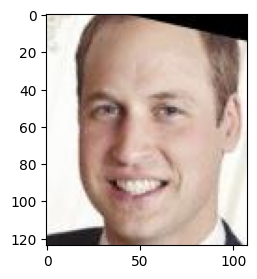

In [21]:
child_base = 'family/child/P06310_face1.jpg'
show_img(child_base)

In [22]:
#Now find closest given we know dad is "most similar"
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]['embedding']
print(embedding)

NameError: name 'DeepFace' is not defined

In [ ]:
query_response = index.query(
      top_k=3,
      vector = embedding,
      filter={
        "person": {"$eq": "dad"}
      },
      include_metadata=True
)

In [ ]:
print(query_response)

In [ ]:
photo = query_response['matches'][0]['metadata']['file']

In [ ]:
show_img(f'family/dad/{photo}')